# Imports & File Preparation

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import imgaug as aug
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
import cv2
import os

In [9]:
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/pneumonia_dataset/Archive.zip', 'r')
zip_ref.extractall("content/dataset")
zip_ref.close()

# Data Preparation

In [10]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [11]:
train = get_training_data('/content/content/dataset/train')

val = get_training_data('/content/content/dataset/val')

test = get_training_data('/content/content/dataset/test')

<ipython-input-10-f7c995ea1462>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<Axes: xlabel='count'>

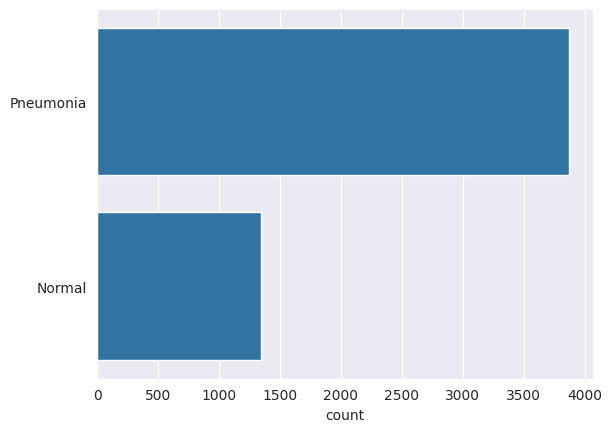

In [12]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

In [13]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [14]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [15]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [16]:
#Here we are using image augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

datagen.fit(x_train)

traingen = datagen.flow(x_train,y_train,batch_size=32)
valgen = datagen.flow(x_val, y_val)

# Model Build

In [17]:
model = Sequential()

#Input layer
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Hidden Layer 1
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Hidden Layer 2
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Hidden Layer 3
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Hidden Layer
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Flatten Layer
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))

#Output Layer
model.add(Dense(units = 1 , activation = 'sigmoid'))


model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 64)        0

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

history = model.fit(traingen, epochs = 12, validation_data = valgen, callbacks=[learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 20s 79ms/step - loss: 0.5134 - accuracy: 0.7490 - val_loss: 0.7213 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 11s 67ms/step - loss: 0.3940 - accuracy: 0.8148 - val_loss: 0.5009 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - 12s 75ms/step - loss: 0.3060 - accuracy: 0.8710 - val_loss: 0.7620 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.8913
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 13s 78ms/step - loss: 0.2598 - accuracy: 0.8913 - val_loss: 0.8200 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/12
163/163 [==============================] - 13s 77ms/step - loss: 0.1971 - accuracy: 0.9214 - val_loss: 1.3215 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 6/12
163/163 [==============================

In [19]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='adam')

# Result Analaysis

In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 9ms/step - loss: 0.3081 - accuracy: 0.8846
Loss of the model is -  0.30806443095207214
20/20 [==============================] - 0s 8ms/step - loss: 0.3081 - accuracy: 0.8846
Accuracy of the model is -  88.46153616905212 %


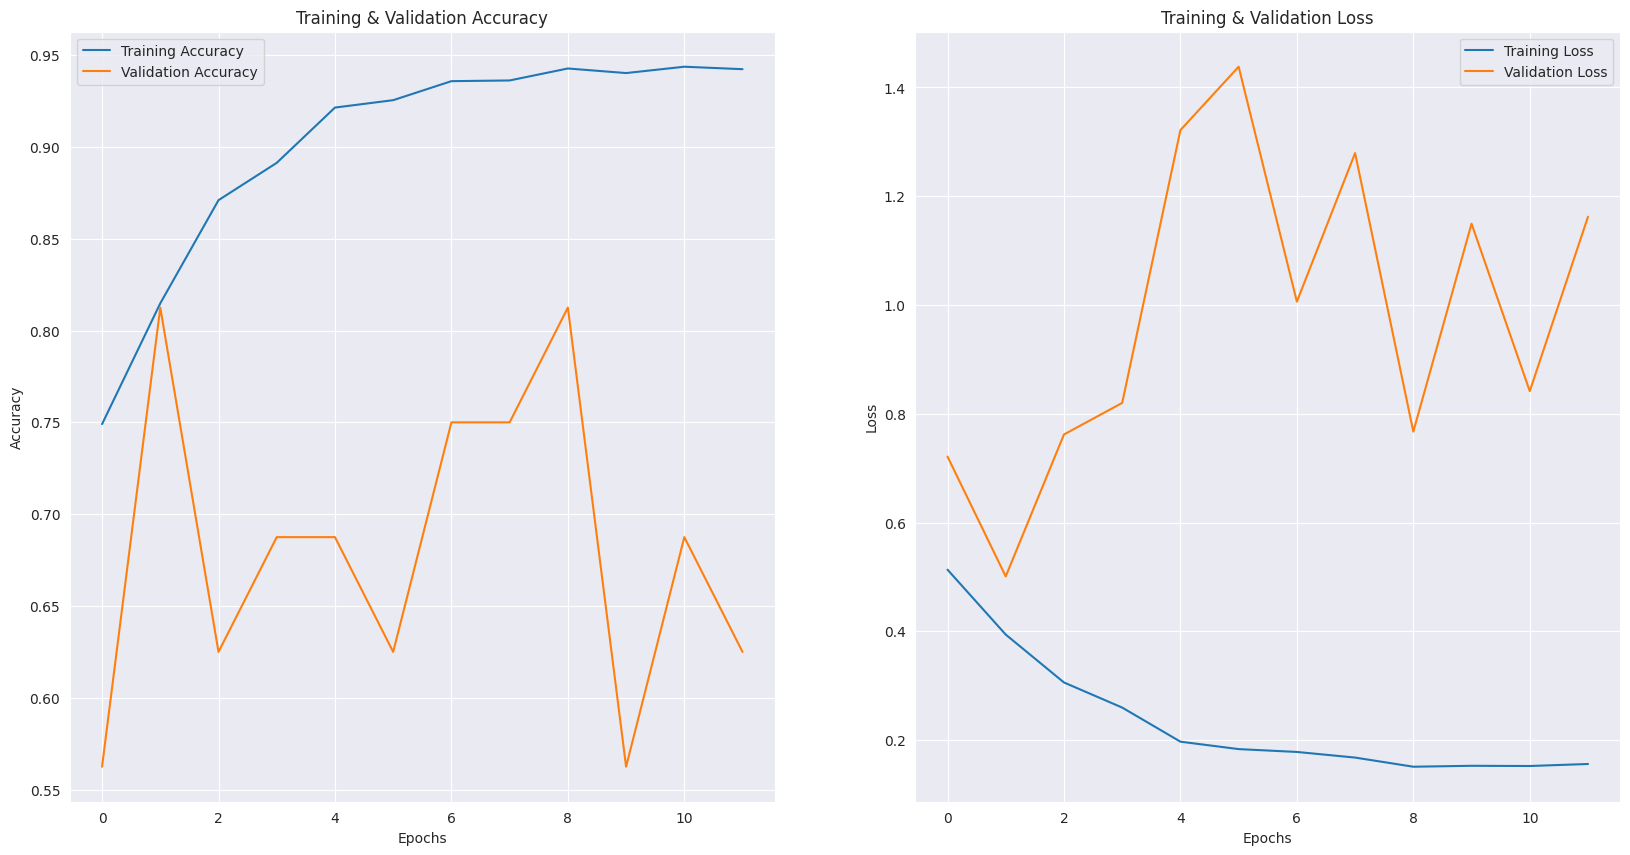

In [21]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, label = 'Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

20/20 [==============================] - 0s 7ms/step


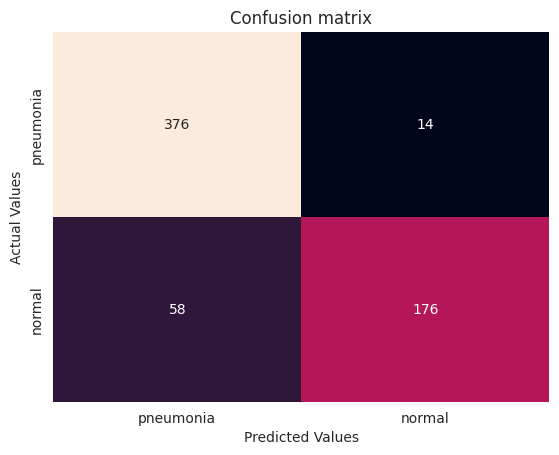

In [22]:
#predicting the model on test data
predictions = (model.predict(x_test) > 0.5).astype("int32")

#Creating confusion matrix
cm=confusion_matrix(y_test,predictions)

#Plotting confusion matrix
labels=['pneumonia','normal']
plt.title('Confusion matrix')
sns.heatmap(cm,cbar=False,fmt='d',annot=True,xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [23]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
f1score=(2*precision*recall/(precision+recall))

print("Recall of the model is {:.2f}%".format(recall))
print("Precision of the model is {:.2f}%".format(precision))
print("F1-Score of the model is {:.2f}%".format(f1score))

Recall of the model is 75.21%
Precision of the model is 92.63%
F1-Score of the model is 83.02%
